In [12]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent   
sys.path.insert(0, str(PROJECT_ROOT))

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from src.data import read_xyz_trajectory, split_dataset, prepare_data, prepare_model_dataset
from src.feature_builders import add_pairwise_distance_features, build_proton_transfer_features, add_angular_acsf_column


In [13]:
DATA_DIR = "../dataset/"

In [14]:
dataset = read_xyz_trajectory(os.path.join(DATA_DIR, "raw/malonaldehyde_300K/structures.xyz"), os.path.join(DATA_DIR, "raw/malonaldehyde_300K/energies.txt"))
test_dataset_unprepared = read_xyz_trajectory(os.path.join(DATA_DIR, "raw/malonaldehyde_300K-test/structures.xyz"), os.path.join(DATA_DIR, "raw/malonaldehyde_300K-test/energies.txt"))
    

train_dataset_unprepared, val_dataset_unprepared = split_dataset(dataset, val_size=0.1, random_state=42)
train_dataset_unprepared.head(15)

,frame,atom_index,element,atomic_number,x,y,z,energy
0,0,0,O,8,7.518784,12.374943,9.872595,-44957.131360
1,0,1,C,6,7.700793,10.111345,10.143338,-44957.131360
2,0,2,C,6,10.074552,8.697429,9.988165,-44957.131360
3,0,3,C,6,12.301752,9.908006,9.874942,-44957.131360
4,0,4,O,8,12.404117,12.447734,10.120959,-44957.131360
5,0,5,H,1,5.978652,8.981591,10.231535,-44957.131360
6,0,6,H,1,9.954607,6.692762,9.916954,-44957.131360
7,0,7,H,1,14.156946,8.958377,9.833734,-44957.131360
8,0,8,H,1,10.442674,12.790426,9.943805,-44957.131360
9,1,0,O,8,7.641590,12.480086,9.958507,-44958.579728


#### High-Dimensional Neural Networks as Proposed by Behler et.al

In [15]:
import numpy as np
import pandas as pd
import math
from itertools import combinations_with_replacement
# ----------------------------
# 1) Cutoff + neighbor list
# ----------------------------
def fc_cos(R, R_cut):
    """Cosine cutoff."""
    if R <= R_cut:
        return 0.5 * (math.cos(math.pi * (R / R_cut)) + 1.0)
    return 0.0

def compute_neighbors(positions, i, R_cut):
    """Return neighbor indices j != i within R_cut."""
    ri = positions[i]
    d = np.linalg.norm(positions - ri, axis=1)
    neigh = np.where((d <= R_cut) & (d > 0.0))[0]
    return neigh.tolist(), d  # also return full dists array for reuse if you want


# ----------------------------
# 2) Behler-style ACSFs (2G)
#    - Element-resolved radial G2
#    - Element-pair-resolved angular G4
# ----------------------------
def acsf_g2_radial_element_resolved(
    positions,
    elements,              # list/array of element strings, length N
    i,
    neigh_idx,
    R_cut,
    radial_params,         # list of dicts: [{"eta":..., "Rs":...}, ...]
    element_types=None     # optional ordered list of unique elements
):
    """
    Returns dict: keys like ("G2", Z, m) -> value
    where Z is neighbor element and m indexes radial_params.
    Definition:
      G2_i(Z,m) = sum_{j in neigh(i), elem(j)=Z} exp(-eta*(Rij - Rs)^2) * fc(Rij)
    """
    if element_types is None:
        element_types = sorted(set(elements))
    out = {}
    ri = positions[i]

    # pre-init
    for Z in element_types:
        for m, _ in enumerate(radial_params):
            out[("G2", Z, m)] = 0.0

    for j in neigh_idx:
        Zj = elements[j]
        R_ij = float(np.linalg.norm(positions[j] - ri))
        f = fc_cos(R_ij, R_cut)
        if f == 0.0:
            continue

        for m, p in enumerate(radial_params):
            eta = p["eta"]
            Rs  = p.get("Rs", 0.0)
            out[("G2", Zj, m)] += math.exp(-eta * (R_ij - Rs) ** 2) * f

    return out


def acsf_g4_angular_elementpair_resolved(
    positions,
    elements,              # list/array of element strings, length N
    i,
    neigh_idx,
    R_cut,
    angular_params,        # list of dicts: [{"eta":..., "zeta":..., "lambda":...}, ...]
    element_types=None,    # optional ordered list of unique elements
    eps=1e-12
):
    """
    Returns dict: keys like ("G4", (Za,Zb), m) -> value  with Za<=Zb
    Behler G4-like definition (common in ACSF literature):
      G4_i(Za,Zb,m) =
        2^(1-zeta) * sum_{j<k in neigh(i), elem(j),elem(k) match Za,Zb}
          (1 + lambda*cos(theta_ijk))^zeta
          * exp(-eta*(Rij^2 + Rik^2 + Rjk^2))
          * fc(Rij) * fc(Rik)

    Notes:
    - Cutoff is applied ONLY to Rij and Rik (central-atom distances). This is the usual choice.
    - Includes Rjk in the exponential term (as in many G4 variants).
    """
    if element_types is None:
        element_types = sorted(set(elements))

    # all unordered element pairs (Za<=Zb)
    pairs = list(combinations_with_replacement(element_types, 2))

    out = {}
    for pair in pairs:
        for m, _ in enumerate(angular_params):
            out[("G4", pair, m)] = 0.0

    ri = positions[i]

    # loop over neighbor pairs j<k
    for a in range(len(neigh_idx)):
        j = neigh_idx[a]
        rj = positions[j]
        vij = rj - ri
        Rij = float(np.linalg.norm(vij))
        fc_ij = fc_cos(Rij, R_cut)
        if fc_ij == 0.0:
            continue

        for b in range(a + 1, len(neigh_idx)):
            k = neigh_idx[b]
            rk = positions[k]
            vik = rk - ri
            Rik = float(np.linalg.norm(vik))
            fc_ik = fc_cos(Rik, R_cut)
            if fc_ik == 0.0:
                continue

            # neighbor-neighbor distance
            Rjk = float(np.linalg.norm(rk - rj))

            # angle at i
            denom = (Rij * Rik) + eps
            cos_theta = float(np.dot(vij, vik) / denom)
            cos_theta = max(-1.0, min(1.0, cos_theta))

            # element pair key (unordered)
            Za, Zb = elements[j], elements[k]
            pair = tuple(sorted((Za, Zb)))

            for m, p in enumerate(angular_params):
                eta     = p["eta"]
                zeta    = p["zeta"]
                lambda_ = p["lambda"]

                ang = (1.0 + lambda_ * cos_theta) ** zeta
                rad = math.exp(-eta * (Rij*Rij + Rik*Rik + Rjk*Rjk))
                out[("G4", pair, m)] += (2.0 ** (1.0 - zeta)) * ang * rad * fc_ij * fc_ik

    return out


# ----------------------------
# 3) Build full ACSF vector per atom, per frame
#    + add to DataFrame as many columns
# ----------------------------
def add_acsf_columns(
    df,
    R_cut=5.5,
    radial_params=None,
    angular_params=None,
    element_col="element",
    pos_cols=("x", "y", "z"),
    frame_col="frame",
    atom_index_col="atom_index",
    prefix="ACSF"
):
    """
    Adds many descriptor columns to df:
      - Radial:  ACSF_G2_<Z>_<m>
      - Angular: ACSF_G4_<Za>-<Zb>_<m>
    Element-resolved and element-pair-resolved.
    """
    if radial_params is None:
        radial_params = [{"eta": e, "Rs": Rs} for e in (0.05, 0.5, 1.0, 2.0, 4.0, 8.0) for Rs in np.linspace(0.0, R_cut, 8)]
    if angular_params is None:
        angular_params = [{"eta": e, "zeta": z, "lambda": lam}
                          for e in (0.0005, 0.005)
                          for z in (1.0, 2.0, 4.0)
                          for lam in (-1.0, 1.0)]

    df = df.copy()
    element_types = sorted(df[element_col].unique().tolist())
    pairs = list(combinations_with_replacement(element_types, 2))

    # Create column names deterministically
    radial_colnames = []
    for Z in element_types:
        for m in range(len(radial_params)):
            radial_colnames.append(f"{prefix}_G2_{Z}_{m}")

    angular_colnames = []
    for (Za, Zb) in pairs:
        for m in range(len(angular_params)):
            angular_colnames.append(f"{prefix}_G4_{Za}-{Zb}_{m}")

    all_cols = radial_colnames + angular_colnames
    for c in all_cols:
        df[c] = np.nan

    # Fill per frame
    for frame_id, g in df.groupby(frame_col, sort=False):
        g_sorted = g.sort_values(atom_index_col)
        idx = g_sorted.index.to_numpy()

        positions = g_sorted.loc[:, list(pos_cols)].to_numpy(dtype=float)
        elems = g_sorted[element_col].astype(str).to_numpy()
        N = positions.shape[0]

        # compute features per atom
        feats = np.zeros((N, len(all_cols)), dtype=float)

        for i in range(N):
            neigh, _ = compute_neighbors(positions, i, R_cut)

            g2 = acsf_g2_radial_element_resolved(
                positions=positions,
                elements=elems,
                i=i,
                neigh_idx=neigh,
                R_cut=R_cut,
                radial_params=radial_params,
                element_types=element_types
            )
            g4 = acsf_g4_angular_elementpair_resolved(
                positions=positions,
                elements=elems,
                i=i,
                neigh_idx=neigh,
                R_cut=R_cut,
                angular_params=angular_params,
                element_types=element_types
            )

            # pack into vector in the same order as column names
            v = []
            for Z in element_types:
                for m in range(len(radial_params)):
                    v.append(g2[("G2", Z, m)])
            for (Za, Zb) in pairs:
                for m in range(len(angular_params)):
                    v.append(g4[("G4", (Za, Zb), m)])

            feats[i, :] = np.asarray(v, dtype=float)

        df.loc[idx, all_cols] = feats

    return df, all_cols, element_types


In [16]:
# 1) Build descriptor columns (radial+angular, element-resolved)
train_dataset, acsf_cols, element_types = add_acsf_columns(train_dataset_unprepared, R_cut=5.5, prefix="ACSF")
val_dataset,   _,        _             = add_acsf_columns(val_dataset_unprepared,   R_cut=5.5, prefix="ACSF")
test_dataset,  _,        _             = add_acsf_columns(test_dataset_unprepared,  R_cut=5.5, prefix="ACSF")


E:\AppData\Temp\ipykernel_17784\3565107906.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c] = np.nan
E:\AppData\Temp\ipykernel_17784\3565107906.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[c] = np.nan
E:\AppData\Temp\ipykernel_17784\3565107906.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfram

KeyboardInterrupt: 

In [ ]:
train_dataset.describe()

,frame,atom_index,atomic_number,x,y,z,energy,ACSF_G2_C_0,ACSF_G2_C_1,ACSF_G2_C_2,...,ACSF_G4_O-O_2,ACSF_G4_O-O_3,ACSF_G4_O-O_4,ACSF_G4_O-O_5,ACSF_G4_O-O_6,ACSF_G4_O-O_7,ACSF_G4_O-O_8,ACSF_G4_O-O_9,ACSF_G4_O-O_10,ACSF_G4_O-O_11
count,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,...,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000,16200.000000
mean,996.356111,4.000000,4.222222,9.999355,10.108853,10.000970,-44953.982464,0.529147,0.629367,0.705678,...,0.057361,0.001646,0.051446,0.000687,0.051701,0.004395,0.048578,0.001273,0.043600,0.000524
std,578.178617,2.582069,2.973222,2.506490,1.952953,0.199188,3.546621,0.148121,0.166695,0.176716,...,0.163816,0.003031,0.148912,0.001440,0.145960,0.008812,0.139041,0.002316,0.126440,0.001096
min,0.000000,0.000000,1.000000,5.619141,6.493508,8.612501,-44961.645867,0.112821,0.150628,0.189234,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,495.750000,2.000000,1.000000,7.649608,8.816977,9.917692,-44956.393865,0.419604,0.502376,0.567900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,998.500000,4.000000,6.000000,9.999796,9.940439,10.000539,-44954.527769,0.521608,0.613794,0.680484,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1494.250000,6.000000,6.000000,12.351546,12.366895,10.082070,-44952.053084,0.649719,0.754168,0.825379,...,0.000718,0.001757,0.000067,0.000421,0.001855,0.004252,0.000557,0.001411,0.000052,0.000324
max,1999.000000,8.000000,8.000000,14.394796,13.537416,11.301125,-44928.723831,0.811236,0.960118,1.068319,...,0.745218,0.017338,0.732365,0.008247,0.652443,0.072303,0.646792,0.014311,0.635636,0.006398


In [ ]:
train_dataset.columns

Index(['frame', 'atom_index', 'element', 'atomic_number', 'x', 'y', 'z',
       'energy', 'ACSF_G2_C_0', 'ACSF_G2_C_1',
       ...
       'ACSF_G4_O-O_2', 'ACSF_G4_O-O_3', 'ACSF_G4_O-O_4', 'ACSF_G4_O-O_5',
       'ACSF_G4_O-O_6', 'ACSF_G4_O-O_7', 'ACSF_G4_O-O_8', 'ACSF_G4_O-O_9',
       'ACSF_G4_O-O_10', 'ACSF_G4_O-O_11'],
      dtype='object', length=224)

In [ ]:
# ----------------------------
# 4) Convert to tensors (frames, atoms, desc_dim) + element ids + energies
# ----------------------------
def build_bp_tensors(
    df,
    feature_cols,
    element_col="element",
    energy_col="energy",
    frame_col="frame",
    atom_index_col="atom_index",
    element_types=None
):
    frames = sorted(df[frame_col].unique())
    atoms_per_frame = df[df[frame_col] == frames[0]].shape[0]

    if element_types is None:
        element_types = sorted(df[element_col].unique().tolist())
    elem_to_id = {e: i for i, e in enumerate(element_types)}

    X_list, Z_list, y_list = [], [], []

    for f in frames:
        g = df[df[frame_col] == f].sort_values(atom_index_col)
        if g.shape[0] != atoms_per_frame:
            raise ValueError(f"Frame {f} has {g.shape[0]} atoms, expected {atoms_per_frame}")

        X = g.loc[:, feature_cols].to_numpy(np.float32)   # (N, D)
        Z = g[element_col].map(elem_to_id).to_numpy(np.int32)
        y = np.float32(g[energy_col].iloc[0])

        X_list.append(X)
        Z_list.append(Z)
        y_list.append(y)

    X_all = np.stack(X_list, axis=0)  # (F, N, D)
    Z_all = np.stack(Z_list, axis=0)  # (F, N)
    y_all = np.asarray(y_list)        # (F,)
    return X_all, Z_all, y_all, elem_to_id

In [ ]:
X_train, Z_train, y_train, elem_to_id = build_bp_tensors(train_dataset, feature_cols=acsf_cols, element_types=element_types)
X_val,   Z_val,   y_val,   _          = build_bp_tensors(val_dataset,   feature_cols=acsf_cols, element_types=element_types)
X_test,  Z_test,  y_test,  _          = build_bp_tensors(test_dataset,  feature_cols=acsf_cols, element_types=element_types)

print("Shapes:", X_train.shape, Z_train.shape, y_train.shape, elem_to_id)

Shapes: (1800, 9, 216) (1800, 9) (1800,) {'C': 0, 'H': 1, 'O': 2}


In [ ]:
print(X_train)

[[[5.1608145e-01 6.0558248e-01 6.6936111e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [3.5923147e-01 4.3698457e-01 5.0042009e-01 ... 2.2358275e-03
   4.7074376e-05 1.0484353e-03]
  [7.4382693e-01 8.8762504e-01 9.9588984e-01 ... 5.4178461e-03
   9.2997652e-05 2.6370788e-03]
  ...
  [7.2156453e-01 8.4775072e-01 9.4056600e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [6.1776769e-01 7.1850020e-01 7.8774655e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [3.3654889e-01 4.3587857e-01 5.3097421e-01 ... 3.3619875e-04
   4.6988964e-01 2.1701518e-07]]

 [[4.4031760e-01 5.2804798e-01 5.9647095e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [4.2799667e-01 5.1153094e-01 5.7564664e-01 ... 4.0905848e-03
   5.2665629e-05 2.0920297e-03]
  [7.5982738e-01 9.0510595e-01 1.0136571e+00 ... 7.5573106e-03
   9.7356162e-05 3.8646262e-03]
  ...
  [6.9947791e-01 8.2510942e-01 9.1895270e-01 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [5.7006377e-01 6.6645348e-01 7.342

In [ ]:
print(Z_train)

[[2 0 0 ... 1 1 1]
 [2 0 0 ... 1 1 1]
 [2 0 0 ... 1 1 1]
 ...
 [2 0 0 ... 1 1 1]
 [2 0 0 ... 1 1 1]
 [2 0 0 ... 1 1 1]]


In [ ]:
def standardize_X_train_apply(X_train, X_val, X_test, eps=1e-12):
    """
    Standardize per descriptor dimension across all atoms+frames in training set.
    """
    # flatten (F,N,D) -> (F*N, D)
    Xf = X_train.reshape(-1, X_train.shape[-1])
    mean = Xf.mean(axis=0)
    std = Xf.std(axis=0) + eps

    def apply(X):
        return (X - mean[None, None, :]) / std[None, None, :]

    return apply(X_train), apply(X_val), apply(X_test), mean, std


In [ ]:
X_train_s, X_val_s, X_test_s, X_mean, X_std = standardize_X_train_apply(X_train, X_val, X_test)


In [ ]:
y_mean = y_train.mean()
y_std  = y_train.std() + 1e-12
y_train_n = (y_train - y_mean) / y_std
y_val_n   = (y_val   - y_mean) / y_std
y_test_n  = (y_test  - y_mean) / y_std

In [ ]:
def stats(name, y):
    print(name, "min", y.min(), "max", y.max(), "std", y.std(), "range", y.max()-y.min())

stats("train", y_train)
stats("val",   y_val)
stats("test",  y_test)


train min -44961.645 max -44928.723 std 3.546503 range 32.921875
val min -44960.293 max -44945.06 std 3.0005493 range 15.234375
test min -44962.023 max -44949.977 std 1.8853621 range 12.046875


In [ ]:
def make_atomic_nn(
    desc_dim,
    hidden=(64, 64),
    activation="tanh",
    name="atomic_nn",
    l2_reg=1e-4,          
    dropout_rate=0.05      
):
    reg = tf.keras.regularizers.l2(l2_reg) if (l2_reg and l2_reg > 0) else None

    inp = tf.keras.layers.Input(shape=(desc_dim,))
    x = inp

    for h in hidden:
        x = tf.keras.layers.Dense(
            h,
            activation=activation,
            kernel_regularizer=reg,
            bias_regularizer=None
        )(x)

        if dropout_rate and dropout_rate > 0:
            x = tf.keras.layers.Dropout(dropout_rate)(x)

    out = tf.keras.layers.Dense(
        1,
        activation=None,
        kernel_regularizer=reg
    )(x)

    return tf.keras.Model(inp, out, name=name)

class BPHDNNP(tf.keras.Model):
    def __init__(self, n_elements, desc_dim, hidden=(64, 64), l2_reg=1e-6, dropout_rate=0.0):
        super().__init__()
        self.n_elements = n_elements
        self.desc_dim = desc_dim
        self.atomic_nns = [
            make_atomic_nn(
                desc_dim,
                hidden=hidden,
                name=f"nn_elem_{e}",
                l2_reg=l2_reg,
                dropout_rate=dropout_rate
            )
            for e in range(n_elements)
        ]

    def call(self, inputs):
        X, Z = inputs
        B = tf.shape(X)[0]
        N = tf.shape(X)[1]

        X_flat = tf.reshape(X, (-1, self.desc_dim))
        Z_flat = tf.reshape(Z, (-1,))

        E_flat = tf.zeros((tf.shape(X_flat)[0], 1), dtype=tf.float32)

        for elem_id, nn in enumerate(self.atomic_nns):
            idx = tf.where(tf.equal(Z_flat, elem_id))
            X_sel = tf.gather_nd(X_flat, idx)
            E_sel = nn(X_sel)
            E_flat = tf.tensor_scatter_nd_update(E_flat, idx, E_sel)

        E_atoms = tf.reshape(E_flat, (B, N, 1))
        E_total = tf.reduce_sum(E_atoms, axis=1)
        return tf.squeeze(E_total, axis=-1)

In [ ]:
# Build + train
n_frames, n_atoms, desc_dim = X_train.shape
n_elements = len(elem_to_id)

model = BPHDNNP(n_elements=n_elements, desc_dim=desc_dim, hidden=(64,64))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse")

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.25,
        patience=30,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    (X_train_s, Z_train), y_train_n,
    validation_data=((X_val_s, Z_val), y_val_n),
    epochs=500,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/500
57/57 [==============================] - 1s 5ms/step - loss: 1.5527 - val_loss: 0.6426 - lr: 1.0000e-04
Epoch 2/500
57/57 [==============================] - 0s 2ms/step - loss: 0.6830 - val_loss: 0.4246 - lr: 1.0000e-04
Epoch 3/500
57/57 [==============================] - 0s 2ms/step - loss: 0.5215 - val_loss: 0.3462 - lr: 1.0000e-04
Epoch 4/500
57/57 [==============================] - 0s 2ms/step - loss: 0.4472 - val_loss: 0.3100 - lr: 1.0000e-04
Epoch 5/500
57/57 [==============================] - 0s 2ms/step - loss: 0.3868 - val_loss: 0.2922 - lr: 1.0000e-04
Epoch 6/500
57/57 [==============================] - 0s 2ms/step - loss: 0.3432 - val_loss: 0.2686 - lr: 1.0000e-04
Epoch 7/500
57/57 [==============================] - 0s 3ms/step - loss: 0.3118 - val_loss: 0.3027 - lr: 1.0000e-04
Epoch 8/500
57/57 [==============================] - 0s 3ms/step - loss: 0.2832 - val_loss: 0.2291 - lr: 1.0000e-04
Epoch 9/500
57/57 [==============================] - 0s 2ms/step - loss:

In [ ]:
y_pred_n = model.predict((X_test_s, Z_test)).ravel()
y_pred   = y_pred_n * y_std + y_mean

mae  = np.mean(np.abs(y_pred - y_test))
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("MAE:", mae, "RMSE:", rmse)


13/13 [==============================] - 0s 1ms/step
MAE: 0.7372461 RMSE: 0.9957186


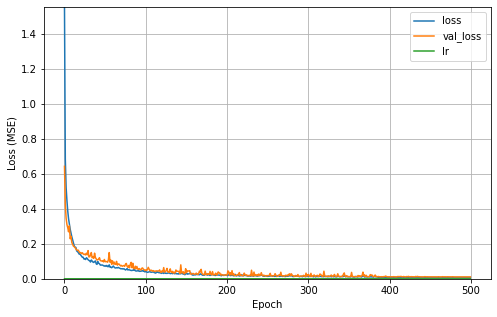

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.show()


13/13 [==============================] - 0s 1ms/step


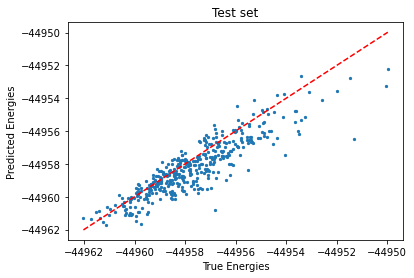

In [ ]:
# Predict normalized
y_pred_n = model.predict((X_test_s, Z_test)).ravel()

# De-normalize back to energy units
y_test_energy = y_test  # already raw energies in your current pipeline
y_pred_energy = y_pred_n * y_std + y_mean

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(y_test_energy, y_pred_energy, s=5)
plt.plot([y_test_energy.min(), y_test_energy.max()],
         [y_test_energy.min(), y_test_energy.max()], 'r--')
plt.xlabel("True Energies")
plt.ylabel("Predicted Energies")
plt.title("Test set")
plt.show()


In [ ]:
from sklearn.metrics import r2_score

err = y_pred_energy - y_test_energy
print("ME (bias):", err.mean())
print("MAE:", np.mean(np.abs(err)))
print("RMSE:", np.sqrt(np.mean(err**2)))
print("R2:", r2_score(y_test_energy, y_pred_energy))



ME (bias): -0.5166797
MAE: 0.7372461
RMSE: 0.9957186
R2: 0.7210774122614293


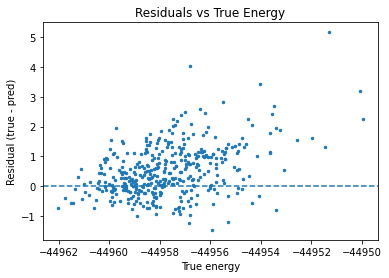

In [ ]:
plt.figure()
plt.scatter(y_test_energy, y_test_energy - y_pred_energy, s=6)
plt.axhline(0, linestyle="--")
plt.xlabel("True energy")
plt.ylabel("Residual (true - pred)")
plt.title("Residuals vs True Energy")
plt.show()


##### coord based MLP

In [ ]:
X_train, y_train, scalars = prepare_data(train_dataset_unprepared)
X_val, y_val, _ = prepare_data(val_dataset_unprepared, scalars=scalars)
X_test, y_test, _ = prepare_data(test_dataset_unprepared, scalars=scalars)

ValueError: scalars['energy_offset'] is None. Did you forget to pass train-fitted scalars?

In [ ]:
X_train.head(25)

,frame,x,y,z,AN_1,AN_6,AN_8
0,0,-1.013978,1.161417,-0.618107,0,0,1
1,0,-0.941331,0.002247,0.785988,0,1,0
2,0,0.006124,-0.721808,-0.018752,0,1,0
3,0,0.895082,-0.101881,-0.605936,0,1,0
4,0,0.935940,1.198693,0.669929,0,0,1
5,0,-1.628701,-0.576291,1.243385,1,0,0
6,0,-0.041750,-1.748381,-0.388058,1,0,0
7,0,1.635559,-0.588178,-0.819644,1,0,0
8,0,0.153055,1.374182,-0.248806,1,0,0
9,1,-0.921041,1.216796,-0.053182,0,0,1


In [ ]:
y_train.head(15)

0    -0.887885
1    -0.887885
2    -0.887885
3    -0.887885
4    -0.887885
5    -0.887885
6    -0.887885
7    -0.887885
8    -0.887885
9    -1.296278
10   -1.296278
11   -1.296278
12   -1.296278
13   -1.296278
14   -1.296278
Name: energy_norm, dtype: float64

In [ ]:

X_train_tensor, y_train_tensor = prepare_model_dataset(X_train, y_train)
X_val_tensor, y_val_tensor = prepare_model_dataset(X_val, y_val)
X_test_tensor, y_test_tensor = prepare_model_dataset(X_test, y_test)

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"X_val_tensor shape: {X_val_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")

X_train_tensor shape: (1800, 9, 6)
y_train_tensor shape: (1800,)
X_val_tensor shape: (200, 9, 6)
X_test_tensor shape: (400, 9, 6)


In [ ]:
X_train_tensor[0]

<tf.Tensor: shape=(9, 6), dtype=float32, numpy=
array([[-1.0139776 ,  1.161417  , -0.61810726,  0.        ,  0.        ,
         1.        ],
       [-0.9413311 ,  0.00224706,  0.7859883 ,  0.        ,  1.        ,
         0.        ],
       [ 0.00612414, -0.7218077 , -0.01875172,  0.        ,  1.        ,
         0.        ],
       [ 0.89508224, -0.10188118, -0.6059356 ,  0.        ,  1.        ,
         0.        ],
       [ 0.9359399 ,  1.1986927 ,  0.6699289 ,  0.        ,  0.        ,
         1.        ],
       [-1.6287014 , -0.5762907 ,  1.2433852 ,  1.        ,  0.        ,
         0.        ],
       [-0.04175036, -1.7483813 , -0.38805786,  1.        ,  0.        ,
         0.        ],
       [ 1.635559  , -0.5881784 , -0.8196436 ,  1.        ,  0.        ,
         0.        ],
       [ 0.15305528,  1.3741825 , -0.24880634,  1.        ,  0.        ,
         0.        ]], dtype=float32)>

In [ ]:
input_layer = tf.keras.layers.Input(shape=X_train_tensor[1].shape) 
flattened = tf.keras.layers.Flatten()(input_layer)  
hidden = tf.keras.layers.Dense(18, activation='relu')(flattened)
hidden_2 = tf.keras.layers.Dense(36, activation='relu')(hidden)
hidden_4 = tf.keras.layers.Dense(18, activation='relu')(hidden_2)
output = tf.keras.layers.Dense(1)(hidden_4)

model = tf.keras.Model(inputs=[input_layer], outputs=[output])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 6)]            0         
                                                                 
 flatten (Flatten)           (None, 54)                0         
                                                                 
 dense (Dense)               (None, 18)                990       
                                                                 
 dense_1 (Dense)             (None, 36)                684       
                                                                 
 dense_2 (Dense)             (None, 18)                666       
                                                                 
 dense_3 (Dense)             (None, 1)                 19        
                                                                 
Total params: 2,359
Trainable params: 2,359
Non-trainable par

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True
    )
]

history = model.fit(
    x=X_train_tensor,
    y=y_train_tensor,
    validation_data=(X_val_tensor, y_val_tensor),
    epochs=500,
    verbose=1,  
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/500


57/57 [==============================] - 1s 3ms/step - loss: 0.9755 - mae: 0.7528 - val_loss: 0.6877 - val_mae: 0.6818
Epoch 2/500
57/57 [==============================] - 0s 1ms/step - loss: 0.9145 - mae: 0.7288 - val_loss: 0.6346 - val_mae: 0.6449
Epoch 3/500
57/57 [==============================] - 0s 1ms/step - loss: 0.8944 - mae: 0.7185 - val_loss: 0.6184 - val_mae: 0.6416
Epoch 4/500
57/57 [==============================] - 0s 1ms/step - loss: 0.8754 - mae: 0.7145 - val_loss: 0.6334 - val_mae: 0.6508
Epoch 5/500
57/57 [==============================] - 0s 1ms/step - loss: 0.8561 - mae: 0.7023 - val_loss: 0.6024 - val_mae: 0.6306
Epoch 6/500
57/57 [==============================] - 0s 2ms/step - loss: 0.8429 - mae: 0.7000 - val_loss: 0.6816 - val_mae: 0.6864
Epoch 7/500
57/57 [==============================] - 0s 1ms/step - loss: 0.8332 - mae: 0.6971 - val_loss: 0.5878 - val_mae: 0.6224
Epoch 8/500
57/57 [==============================] - 0s 1ms/step - loss: 0.8170 - mae: 0.6900 -

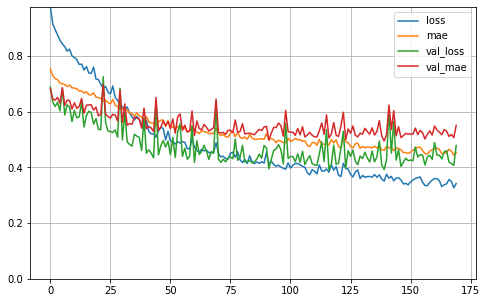

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))
plt.show()


In [ ]:
train_mse, train_mae = model.evaluate(
    X_train_tensor, y_train_tensor, verbose=0
)

test_mse, test_mae = model.evaluate(
    X_test_tensor, y_test_tensor, verbose=0
)

print(f"Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test  MSE: {test_mse:.4f}, Test  MAE: {test_mae:.4f}")


Train MSE: 0.3742, Train MAE: 0.4669
Test  MSE: 0.3841, Test  MAE: 0.4841


#### interatomic dist MLP

In [ ]:
train_dataset = add_pairwise_distance_features(train_dataset_unprepared)
val_dataset = add_pairwise_distance_features(val_dataset_unprepared)
test_dataset = add_pairwise_distance_features(test_dataset_unprepared)

In [ ]:
train_dataset.head(5)

,frame,atom_index,element,atomic_number,x,y,z,energy,dist_atom0_atom1,dist_atom0_atom2,...,dist_atom4_atom5,dist_atom4_atom6,dist_atom4_atom7,dist_atom4_atom8,dist_atom5_atom6,dist_atom5_atom7,dist_atom5_atom8,dist_atom6_atom7,dist_atom6_atom8,dist_atom7_atom8
0,0,0,O,8,7.518784,12.374943,9.872595,-44957.13136,2.286986,4.47989,...,7.301573,6.257909,3.915421,1.99902,4.598469,8.187996,5.87516,4.774892,6.117225,5.33784
1,0,1,C,6,7.700793,10.111345,10.143338,-44957.13136,2.286986,4.47989,...,7.301573,6.257909,3.915421,1.99902,4.598469,8.187996,5.87516,4.774892,6.117225,5.33784
2,0,2,C,6,10.074552,8.697429,9.988165,-44957.13136,2.286986,4.47989,...,7.301573,6.257909,3.915421,1.99902,4.598469,8.187996,5.87516,4.774892,6.117225,5.33784
3,0,3,C,6,12.301752,9.908006,9.874942,-44957.13136,2.286986,4.47989,...,7.301573,6.257909,3.915421,1.99902,4.598469,8.187996,5.87516,4.774892,6.117225,5.33784
4,0,4,O,8,12.404117,12.447734,10.120959,-44957.13136,2.286986,4.47989,...,7.301573,6.257909,3.915421,1.99902,4.598469,8.187996,5.87516,4.774892,6.117225,5.33784


In [ ]:
pt_df = build_proton_transfer_features(train_dataset)   
pt_df_val = build_proton_transfer_features(val_dataset)   
pt_df_test = build_proton_transfer_features(test_dataset)   

train_dataset = train_dataset.merge(pt_df, left_on="frame", right_index=True, how="left")
val_dataset = val_dataset.merge(pt_df_val, left_on="frame", right_index=True, how="left")
test_dataset = test_dataset.merge(pt_df_test, left_on="frame", right_index=True, how="left")

In [ ]:
train_dataset.head(5)

,frame,atom_index,element,atomic_number,x,y,z,energy,dist_atom0_atom1,dist_atom0_atom2,...,dist_atom4_atom8,dist_atom5_atom6,dist_atom5_atom7,dist_atom5_atom8,dist_atom6_atom7,dist_atom6_atom8,dist_atom7_atom8,pt_q,pt_d1,pt_d2
0,0,0,O,8,7.518784,12.374943,9.872595,-44957.13136,2.286986,4.47989,...,1.99902,4.598469,8.187996,5.87516,4.774892,6.117225,5.33784,0.955101,2.954121,1.99902
1,0,1,C,6,7.700793,10.111345,10.143338,-44957.13136,2.286986,4.47989,...,1.99902,4.598469,8.187996,5.87516,4.774892,6.117225,5.33784,0.955101,2.954121,1.99902
2,0,2,C,6,10.074552,8.697429,9.988165,-44957.13136,2.286986,4.47989,...,1.99902,4.598469,8.187996,5.87516,4.774892,6.117225,5.33784,0.955101,2.954121,1.99902
3,0,3,C,6,12.301752,9.908006,9.874942,-44957.13136,2.286986,4.47989,...,1.99902,4.598469,8.187996,5.87516,4.774892,6.117225,5.33784,0.955101,2.954121,1.99902
4,0,4,O,8,12.404117,12.447734,10.120959,-44957.13136,2.286986,4.47989,...,1.99902,4.598469,8.187996,5.87516,4.774892,6.117225,5.33784,0.955101,2.954121,1.99902


In [ ]:
X_train, y_train, scalars = prepare_data(train_dataset, interatomic_distance=True)
X_val,   y_val,   _       = prepare_data(val_dataset, scalars=scalars, interatomic_distance=True)
X_test,  y_test,  _       = prepare_data(test_dataset, scalars=scalars, interatomic_distance=True)


In [ ]:
X_train.head(5)

,dist_atom0_atom1,dist_atom0_atom2,dist_atom0_atom3,dist_atom0_atom4,dist_atom0_atom5,dist_atom0_atom6,dist_atom0_atom7,dist_atom0_atom8,dist_atom1_atom2,dist_atom1_atom3,...,dist_atom4_atom8,dist_atom5_atom6,dist_atom5_atom7,dist_atom5_atom8,dist_atom6_atom7,dist_atom6_atom8,dist_atom7_atom8,pt_q,pt_d1,pt_d2
frame,,,,,,,,,,,,,,,,,,,,,
0,-0.957072,1.365100,0.457370,0.072612,-1.420944,0.075836,0.630394,0.721784,0.890054,-0.823613,...,-0.827326,-0.395975,0.028077,0.318929,0.794682,-0.536298,-0.822565,0.782185,0.721784,-0.827326
1,1.414421,0.646148,-0.421875,-1.549666,0.850499,0.959885,0.634871,-1.032922,-0.805467,-1.203851,...,0.632191,-0.180545,0.723094,-0.904256,1.050628,0.262092,0.978242,-0.841893,-1.032922,0.632191
2,-1.939966,-1.162989,-0.953879,0.391530,-1.006166,-0.404959,-1.211685,1.004559,0.262213,-1.526850,...,-1.004165,-0.509798,-0.647654,0.847536,0.949827,0.148043,-1.403232,1.014558,1.004559,-1.004165
3,1.269561,0.527938,-1.244226,0.114199,0.436580,1.955695,0.056079,-0.888533,-0.689636,-0.796052,...,0.874046,2.196051,0.402373,-0.696175,-1.566785,0.769400,0.883998,-0.890267,-0.888533,0.874046
4,1.595123,0.267113,-0.289276,1.034039,-0.480715,0.728966,-1.205702,-1.035664,-0.666834,0.609411,...,1.280949,1.044575,-0.445352,-0.933377,-0.632461,0.709506,0.801047,-1.169522,-1.035664,1.280949


In [ ]:
y_train.head(5)

frame
0   -0.887885
1   -1.296278
2    1.136285
3   -1.063613
4   -0.745032
Name: energy_norm, dtype: float64

In [ ]:
X_train.shape, y_train.shape

((1800, 39), (1800,))

In [ ]:
X_val.head(5)

,dist_atom0_atom1,dist_atom0_atom2,dist_atom0_atom3,dist_atom0_atom4,dist_atom0_atom5,dist_atom0_atom6,dist_atom0_atom7,dist_atom0_atom8,dist_atom1_atom2,dist_atom1_atom3,...,dist_atom4_atom8,dist_atom5_atom6,dist_atom5_atom7,dist_atom5_atom8,dist_atom6_atom7,dist_atom6_atom8,dist_atom7_atom8,pt_q,pt_d1,pt_d2
frame,,,,,,,,,,,,,,,,,,,,,
29,-1.727055,-0.672403,-0.794498,0.396567,-0.515449,-0.259836,-0.819669,1.139033,0.817122,-0.551597,...,-0.998085,0.028197,-0.812660,1.167992,-0.713338,0.591424,-1.023069,1.079717,1.139033,-0.998085
49,-0.875478,0.240041,0.495825,-0.576504,-0.864614,0.576201,0.028698,0.760418,0.832814,1.168105,...,-0.951253,0.840051,0.144056,0.662485,-0.433117,0.133039,-0.745267,0.864101,0.760418,-0.951253
56,0.378925,0.256070,1.267713,1.453775,-2.154220,0.119230,0.806447,-0.916473,-0.854169,0.350098,...,1.190505,-0.969623,-1.108752,-1.432713,0.245862,-0.554323,0.931869,-1.063577,-0.916473,1.190505
65,0.808627,-0.804943,-0.395835,-0.036285,-0.273260,0.052269,-0.207356,-0.836038,-1.238886,-0.230202,...,0.794197,0.204721,-0.339670,-0.828213,-0.675933,-0.098684,0.776145,-0.823483,-0.836038,0.794197
69,-1.275114,0.683787,-0.066359,-1.138048,-0.981648,-0.986025,-0.036326,0.658927,1.632522,0.848907,...,-1.041327,-0.032728,0.684029,0.396821,0.458774,-1.388568,-0.997813,0.857912,0.658927,-1.041327


In [ ]:
X_train_tensor = tf.convert_to_tensor(X_train.values, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)

X_val_tensor   = tf.convert_to_tensor(X_val.values, dtype=tf.float32)
y_val_tensor   = tf.convert_to_tensor(y_val.values, dtype=tf.float32)

X_test_tensor  = tf.convert_to_tensor(X_test.values, dtype=tf.float32)
y_test_tensor  = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

In [ ]:
inp = tf.keras.layers.Input(shape=(X_train.shape[1],))

x = tf.keras.layers.Dense(
    256, activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(1e-4)
)(inp)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.10)(x)

x = tf.keras.layers.Dense(
    256, activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(1e-4)
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.10)(x)

x = tf.keras.layers.Dense(
    128, activation="relu",
    kernel_regularizer=tf.keras.regularizers.l2(1e-4)
)(x)
x = tf.keras.layers.BatchNormalization()(x)

out = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inp, out)


In [ ]:
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 39)]              0         
                                                                 
 dense_59 (Dense)            (None, 256)               10240     
                                                                 
 batch_normalization_29 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_60 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_30 (Bat  (None, 256)              1024      
 chNormalization)                                         

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.Huber(delta=1.0),   
    metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.25,
        patience=30,
        min_lr=1e-6,
        verbose=1
    )
]

history = model.fit(
    x=X_train_tensor,
    y=y_train_tensor,
    validation_data=(X_val_tensor, y_val_tensor),
    epochs=1000,          
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

energy_scaler = scalars["energy"]          
energy_offset = scalars["energy_offset"]   

sigma_E = float(energy_scaler.scale_[0])  

print("Training energy offset (mean):", energy_offset)
print("Training energy std (sigma):", sigma_E)


Epoch 1/1000


57/57 [==============================] - 1s 6ms/step - loss: 0.5471 - mae: 0.8780 - val_loss: 0.3557 - val_mae: 0.6656 - lr: 3.0000e-04
Epoch 2/1000
57/57 [==============================] - 0s 3ms/step - loss: 0.3500 - mae: 0.6454 - val_loss: 0.2929 - val_mae: 0.5820 - lr: 3.0000e-04
Epoch 3/1000
57/57 [==============================] - 0s 3ms/step - loss: 0.3092 - mae: 0.5947 - val_loss: 0.2506 - val_mae: 0.5299 - lr: 3.0000e-04
Epoch 4/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.2665 - mae: 0.5287 - val_loss: 0.2097 - val_mae: 0.4592 - lr: 3.0000e-04
Epoch 5/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.2475 - mae: 0.5116 - val_loss: 0.1996 - val_mae: 0.4408 - lr: 3.0000e-04
Epoch 6/1000
57/57 [==============================] - 0s 4ms/step - loss: 0.2241 - mae: 0.4716 - val_loss: 0.1794 - val_mae: 0.4064 - lr: 3.0000e-04
Epoch 7/1000
57/57 [==============================] - 0s 3ms/step - loss: 0.2237 - mae: 0.4713 - val_loss: 0.1757 - val

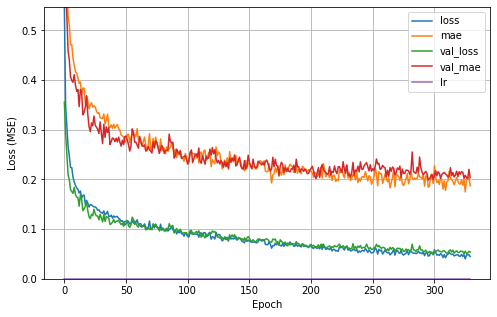

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])))
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.show()


In [ ]:
train_mse, train_mae = model.evaluate(
    X_train_tensor, y_train_tensor, verbose=0
)

test_mse, test_mae = model.evaluate(
    X_test_tensor, y_test_tensor, verbose=0
)

print(f"Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test  MSE: {test_mse:.4f}, Test  MAE: {test_mae:.4f}")


Train MSE: 0.0247, Train MAE: 0.0875
Test  MSE: 0.0749, Test  MAE: 0.2645


In [ ]:
test_mse, test_mae = model.evaluate(
    X_test_tensor, y_test_tensor, verbose=0
)

print("Test MAE (normalized units):", test_mae)
print("Test MAE (raw energy units):", test_mae * sigma_E)


Test MAE (normalized units): 0.2645149230957031
Test MAE (raw energy units): 0.9381052649772198


 1/13 [=>............................] - ETA: 0s

13/13 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'Test set')

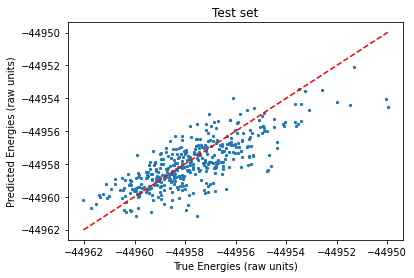

In [ ]:
y_test_pred = model.predict(X_test_tensor)

energy_scaler = scalars["energy"]
energy_offset = scalars.get("energy_offset", 0.0) 

y_test_rel = energy_scaler.inverse_transform(y_test.to_numpy().reshape(-1, 1)).ravel()
y_pred_rel = energy_scaler.inverse_transform(y_test_pred).ravel()

y_test_energy = y_test_rel + energy_offset
y_test_pred_energy = y_pred_rel + energy_offset

plt.figure()
plt.scatter(y_test_energy, y_test_pred_energy, s=5)
plt.plot([y_test_energy.min(), y_test_energy.max()],
         [y_test_energy.min(), y_test_energy.max()], 'r--')
plt.xlabel("True Energies (raw units)")
plt.ylabel("Predicted Energies (raw units)")
plt.title("Test set")


Text(0.5, 1.0, 'Residuals Histogram')

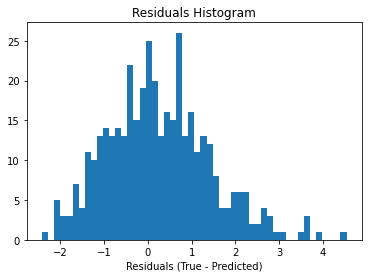

In [ ]:
residuals = y_test_energy - y_test_pred_energy
plt.hist(residuals, bins=50)
plt.xlabel("Residuals (True - Predicted)")
plt.title("Residuals Histogram")


In [ ]:
print("Mean Absolute Error (raw energy units):", np.mean(np.abs(residuals)))
print("Root Mean Squared Error (raw energy units):", np.sqrt(np.mean(residuals**2)))
print(y_test_pred_energy.min(), y_test_pred_energy.max())
print(y_test_energy.min(), y_test_energy.max())

Mean Absolute Error (raw energy units): 0.9382826077453137
Root Mean Squared Error (raw energy units): 1.2036165960746048
-44961.19 -44952.066
-44962.025344694244 -44949.974633241596


Tolerance ±0.50: 136/400 (34.0%)
Tolerance ±1.00: 243/400 (60.8%)
Tolerance ±2.00: 359/400 (89.8%)


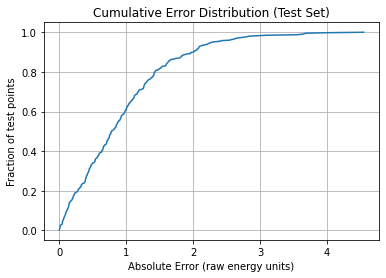

In [ ]:
# absolute errors
abs_errors = np.abs(residuals)

# choose tolerances (you can add more)
tolerances = [0.5, 1.0, 2.0]

for eps in tolerances:
    frac_correct = np.mean(abs_errors <= eps)
    n_correct = np.sum(abs_errors <= eps)
    n_total = len(abs_errors)
    print(f"Tolerance ±{eps:.2f}: {n_correct}/{n_total} ({100*frac_correct:.1f}%)")


sorted_errors = np.sort(abs_errors)
cdf = np.arange(1, len(sorted_errors)+1) / len(sorted_errors)

plt.figure()
plt.plot(sorted_errors, cdf)
plt.xlabel("Absolute Error (raw energy units)")
plt.ylabel("Fraction of test points")
plt.title("Cumulative Error Distribution (Test Set)")
plt.grid(True)


In [ ]:
def atom_signature_per_frame(df, n_frames=5):
    sigs = []
    for f in sorted(df["frame"].unique())[:n_frames]:
        g = df[df["frame"] == f].sort_values("atom_index")
        sigs.append(tuple(g["atomic_number"].tolist()))
    return sigs

train_sigs = atom_signature_per_frame(train_dataset_unprepared, n_frames=10)
test_sigs  = atom_signature_per_frame(test_dataset_unprepared, n_frames=10)

print("Train signatures (first 3):", train_sigs[:3])
print("Test  signatures (first 3):", test_sigs[:3])
print("All equal for sampled frames?", train_sigs == test_sigs)


Train signatures (first 3): [(8, 6, 6, 6, 8, 1, 1, 1, 1), (8, 6, 6, 6, 8, 1, 1, 1, 1), (8, 6, 6, 6, 8, 1, 1, 1, 1)]
Test  signatures (first 3): [(8, 6, 6, 6, 8, 1, 1, 1, 1), (8, 6, 6, 6, 8, 1, 1, 1, 1), (8, 6, 6, 6, 8, 1, 1, 1, 1)]
All equal for sampled frames? True


In [ ]:
def frame_energies(df):
    return df[["frame","energy"]].drop_duplicates().set_index("frame")["energy"]

E_train = frame_energies(train_dataset_unprepared)
E_val   = frame_energies(val_dataset_unprepared)
E_test  = frame_energies(test_dataset_unprepared)

print("Train energy min/max:", E_train.min(), E_train.max())
print("Test  energy min/max:", E_test.min(),  E_test.max())
print("Fraction of test outside train range:",
      ((E_test < E_train.min()) | (E_test > E_train.max())).mean())


Train energy min/max: -44961.6458674344 -44928.7238313888
Test  energy min/max: -44962.025344694244 -44949.974633241596
Fraction of test outside train range: 0.005


In [ ]:
print("Same columns?", list(X_train.columns) == list(X_test.columns))
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# If not same, show differences:
train_cols = set(X_train.columns)
test_cols  = set(X_test.columns)
print("Only in train:", sorted(train_cols - test_cols))
print("Only in test :", sorted(test_cols - train_cols))


Same columns? True
Train shape: (1800, 39) Test shape: (400, 39)
Only in train: []
Only in test : []


In [ ]:
import numpy as np
def check_bad_values(X, name):
    bad = ~np.isfinite(X.to_numpy()).all()
    print(name, "all finite?", not bad)
    if bad:
        mask = ~np.isfinite(X.to_numpy())
        print(name, "num bad entries:", mask.sum())

check_bad_values(X_train, "X_train")
check_bad_values(X_val,   "X_val")
check_bad_values(X_test,  "X_test")


X_train all finite? True
X_val all finite? True
X_test all finite? True


In [ ]:
import numpy as np

Xtr = X_train.to_numpy()
Xte = X_test.to_numpy()

mu = Xtr.mean(axis=0)
cov = np.cov(Xtr, rowvar=False)
cov += np.eye(cov.shape[0]) * 1e-8  # tiny jitter
inv_cov = np.linalg.inv(cov)

def mahalanobis(X):
    d = X - mu
    return np.sqrt(np.einsum("bi,ij,bj->b", d, inv_cov, d))

m_tr = mahalanobis(Xtr)
m_te = mahalanobis(Xte)

print("Mahalanobis distance: train mean/std", m_tr.mean(), m_tr.std())
print("Mahalanobis distance: test  mean/std", m_te.mean(), m_te.std())
print("Fraction of test above 95th percentile of train:",
      (m_te > np.quantile(m_tr, 0.95)).mean())


Mahalanobis distance: train mean/std 5.707882756924793 1.8438509909554042
Mahalanobis distance: test  mean/std 8.29261505731578 2.344602659218478
Fraction of test above 95th percentile of train: 0.255
